## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This Notebook aims to compute the upper branch of the MOC at the 34.5oS (SAMBAR) for the future SSP370 scenario. The upper branch is the integrated volume transport from the surface to the level where the meridional volume transport inverts.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np  
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import cumtrapz
from scipy import integrate

## Dask

In [2]:
mem_per_worker = 25 # memory per worker in GB 
num_workers = 80 # number of workers
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.61:44309' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.61:44309,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM ssp370 file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['MOC'],frequency='month_1')

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={'consolidated': True}, storage_options={'anon': True})
print(f'\nDataset dictionary keys:\n {dset_dict_raw.keys()}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.cmip6.MOC', 'ocn.ssp370.pop.h.cmip6.MOC', 'ocn.historical.pop.h.smbb.MOC', 'ocn.ssp370.pop.h.smbb.MOC'])


In [8]:
%%time
fb=('cmip6','smbb')
for ifb in range(0,2):
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.ssp370.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'2015-02-01\', \'2100-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Yearly average
    exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # cm to m and negative depth
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
CPU times: user 4.66 s, sys: 24.8 ms, total: 4.68 s
Wall time: 4.84 s


In [9]:
ds_moc=xr.combine_nested([moc_cmip6,moc_smbb],concat_dim=['member_id']); del moc_cmip6, moc_smbb

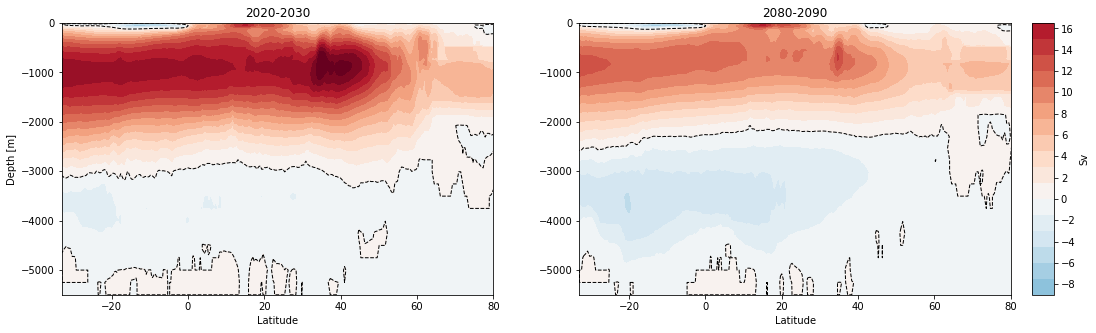

In [14]:
Z1 = ds_moc.isel(transport_reg=1).sel(time=slice('2020-01-01','2030-01-01')).mean(dim=['member_id','time']).sum(dim='moc_comp')
Z2 = ds_moc.isel(transport_reg=1).sel(time=slice('2080-01-01','2090-01-01')).mean(dim=['member_id','time']).sum(dim='moc_comp')
X, Y = np.meshgrid(ds_moc['lat_aux_grid'],ds_moc['moc_z'])
mn=-20
mx=20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17, 5])

im1 = ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

axins = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
im = ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax1.set_title('2020-2030')
ax2.set_title('2080-2090')
ax1.set_xlabel('Latitude')
ax2.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
ax1.set_xlim(-33.008255,80)
ax2.set_xlim(-33.008255,80)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> Notice that we limited the southernmost latitude (34.34514005S) so that we could use the mask that covers the Atlantic
</div>

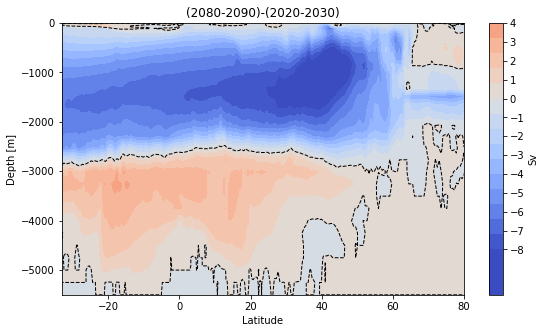

In [20]:
# Plot
fig, (ax3) = plt.subplots(figsize=(9, 5)) 
cs1 = ax3.contourf(X, Y, abs(Z2)-abs(Z1), 20, vmin=-8, vmax=8, cmap="coolwarm")
ax3.contour(X, Y, abs(Z2)-abs(Z1), levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax3.set_title('(2080-2090)-(2020-2030)')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth [m]') 
ax3.set_xlim(-33.008255,80)
plt.colorbar(cs1,ticks=range(-8, 8),label='Sv')
#plt.colorbar(cs1,ticks=range(-10, 10),label='Sv')
plt.show()

In [21]:
Z1 = ds_moc.isel(transport_reg=1,lat_aux_grid=87).mean(dim='member_id').sum(dim='moc_comp')
Z1_max=np.sort(np.max(Z1, axis=0).values)[-4] # I chose a region of maximum, selecting the fourth maximum value of all the years
print(round(Z1_max,1))

Z2 = ds_moc.isel(transport_reg=1,lat_aux_grid=146).mean(dim='member_id').sum(dim='moc_comp')
Z2_max=np.sort(np.max(Z2, axis=0).values)[-4]
print(round(Z2_max,1))

Z3 = ds_moc.isel(transport_reg=1,lat_aux_grid=274).mean(dim='member_id').sum(dim='moc_comp')
Z3_max=np.sort(np.max(Z3, axis=0).values)[-4]
print(round(Z3_max,1))

Z4 = ds_moc.isel(transport_reg=1,lat_aux_grid=300).mean(dim='member_id').sum(dim='moc_comp')
Z4_max=np.sort(np.max(Z4, axis=0).values)[-4]
print(round(Z4_max,1))

X, Y = np.meshgrid(ds_moc['moc_z'],ds_moc['time'])

18.4
17.4
17.4
20.7


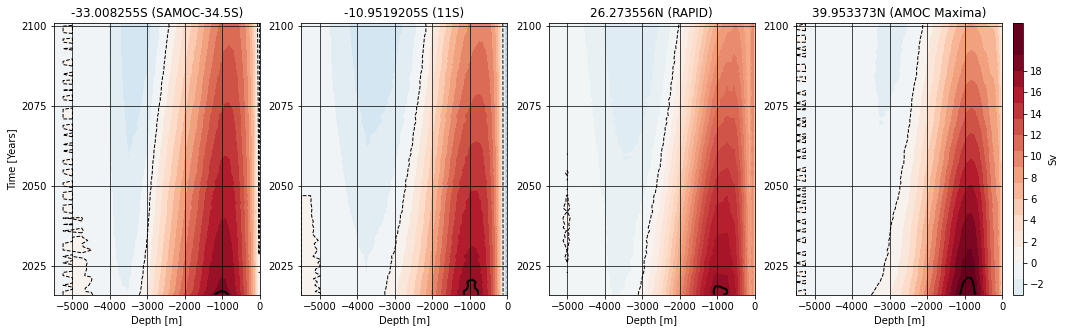

CPU times: user 2min 47s, sys: 2.62 s, total: 2min 50s
Wall time: 3min 4s


In [22]:
%%time
#Figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[17, 5])
ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax3.contourf(X, Y, Z3, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

im = ax4.contourf(X, Y, Z4, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
axins = inset_axes(ax4, width='5%', height='100%', loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')

# Subplots
fmax=10
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax1.contour(X, Y, Z1, levels = [18.4], colors=('k',), linestyles=('-',), linewidths=(2,))
ax1.clabel(CS, inline=True, fontsize=fmax); del CS

ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax2.contour(X, Y, Z2, levels = [17.4], colors=('k',), linestyles=('-',), linewidths=(2,))
ax2.clabel(CS, inline=True, fontsize=fmax); del CS

ax3.contour(X, Y, Z3, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax3.contour(X, Y, Z3, levels = [17.4], colors=('k',), linestyles=('-',), linewidths=(2,))
ax3.clabel(CS, inline=True, fontsize=fmax); del CS

ax4.contour(X, Y, Z4, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax4.contour(X, Y, Z4, levels = [20.4], colors=('k',), linestyles=('-',), linewidths=(2,))
ax4.clabel(CS, inline=True, fontsize=fmax); del CS

#Labels
ax1.set_title('-33.008255S (SAMOC-34.5S)'); ax2.set_title('-10.9519205S (11S)'); ax3.set_title('26.273556N (RAPID)'); ax4.set_title('39.953373N (AMOC Maxima)')
ax1.set_xlabel('Depth [m]'); ax2.set_xlabel('Depth [m]'); ax3.set_xlabel('Depth [m]'); ax4.set_xlabel('Depth [m]')
ax1.set_ylabel('Time [Years]')
ax1.grid(color='k', linestyle='-', linewidth=0.7); ax2.grid(color='k', linestyle='-', linewidth=0.7); ax3.grid(color='k', linestyle='-', linewidth=0.7); ax4.grid(color='k', linestyle='-', linewidth=0.7)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> Can we say that the weakening in the South Atlantic is faster than in other basins? The South Atlantic is the warmest basin and this may not be by chance. 

### Let's read the data again since we need a monthly series 

In [ ]:
fb=('cmip6','smbb')
for ifb in range(0,2):
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.ssp370.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'2009-01-01\', \'2014-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc[\'moc_z\'] = -0.01*ds_{fb[ifb]}_moc[\'moc_z\']' # cm to m and negative depth
    exec(str)
    str=f'ds_{fb[ifb]}_moc[\'dz\'] = 0.01*ds_{fb[ifb]}_moc[\'dz\']' # cm to m and negative depth
    exec(str)

In [ ]:
ds_moc=xr.combine_nested([ds_cmip6_moc,ds_smbb_moc],concat_dim=['member_id']); del ds_cmip6_moc; del ds_smbb_moc

### What does the vertical profile of AMOC look like?

In [ ]:
ila=87
alpha=0.05
moc_mean=ds_moc.isel(transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').mean(dim='time')
moc_mean.plot.line(y='moc_z',color='black',alpha=alpha,linewidth=1,add_legend=False)
moc_mean.mean(dim='member_id').plot.line(y='moc_z',color='black',linewidth=1,label='LENS2')

plt.xlabel("Volume Transport [Sv]")
plt.ylabel("Depth [m]")
plt.title('AMOC at 33.008255S [ssp370: 2009-01 to 2014-12]')
plt.grid(color='k', linestyle='-', linewidth=0.4)
bbox_props = dict(boxstyle='round', fc='w', ec='0.5', alpha=0.9)
plt.xlim(-2, 20)
plt.legend()
plt.show()

#### Interpolate to create MOC data in the middle of the layer

In [ ]:
ila=87
prof = np.empty((len(ds_moc['moc_z'])-1)) * np.nan
for t in range(0,len(ds_moc.coords['moc_z'])-1): 
        prof[t]=(ds_moc.coords['moc_z'][t]+ds_moc.coords['moc_z'][t+1])/2 
ds_moc.MOC.interp(moc_z=prof,method='cubic').isel(member_id=0,time=0,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').plot()
ds_moc.MOC.isel(member_id=0,time=0,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').plot()
ds_moc_int=ds_moc.interp(moc_z=prof,method='cubic')

In [ ]:
%%time
y_int = np.empty((len(ds_moc_int['member_id']),len(ds_moc['time']))) * np.nan
for it in range(0,len(ds_moc_int['time'])): # time 
    print(f'Time: {it}')
    amoc = ds_moc_int.MOC.isel(time=it,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp')
    for im in range(0,10): # members (50 member in total)
    #for im in range(0,len(ds_moc_int['member_id'])): # members (50 member in total)
        L = np.where(amoc.isel(member_id=im,moc_z=slice(46,61))<0) # Notes: 40=-1041.3682m; 60=-5499.9907m
        if len(amoc['moc_z'][L])==0: # If there is no negative transport in this interval (moc_z=slice(46,61)), the integral is done from surface to bottom.     
            #y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,-1))*(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z")))/sum(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z"))
            y_int[im,it]=sum(amoc.isel(member_id=im)*ds_moc.dz.isel(member_id=im).values)/sum(ds_moc.dz.isel(member_id=im).values)
        else:
            #y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,L[0][0]-1+46))*(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff('moc_z')))/sum(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff('moc_z'))
            y_int[im,it]=sum(amoc.isel(member_id=im,moc_z=slice(0,L[0][0]-1+46))*ds_moc.dz.isel(member_id=im)[0:L[0][0]-1+46].values)/sum(ds_moc.dz.isel(member_id=im)[0:L[0][0]-1+46].values)

In [ ]:
ds_MOC_SAMOC = xr.Dataset({'MOC_SAMOC': (('member_id','time'), y_int)},coords={'member_id': ds_moc.coords['member_id'],'time': ds_moc.coords['time']})
ds_MOC_SAMOC.attrs['description'] = 'Meridional Overturning Circulation (MOC) upper branch from the surface to the level where the transport volume reverses sign for the period from 2009 to 2014'
ds_MOC_SAMOC.attrs['units'] = 'Sv'
ds_MOC_SAMOC.attrs['author'] = 'Mauricio Rocha'
ds_MOC_SAMOC.attrs['email'] = 'mauricio.rocha@usp.br'
ds_MOC_SAMOC['time'] = ds_MOC_SAMOC['time'].astype('datetime64[ns]')

In [ ]:
# create a directory on scratch to save the output
path = '/glade/scratch/mauricio/LENS2_ssp370_south_atlantic/MOC_SAMOC/'.format(getpass.getuser())
os.system('mkdir -p '+path)
ds_MOC_SAMOC.to_netcdf(path+'MOC_SAMOC.nc')